# Titanic: Machine Learning from Disaster

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None #shut up the warning for which we are modifying the original df
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Gather the data

> ## Load data

In [2]:
### training set

train_data = pd.read_csv("train.csv")
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
### test set
test_data = pd.read_csv("test.csv")
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Feature Engineering

> ## Pivot analysis



At first, we can analyze our **feature correlations** by pivoting each features against the *Survived* one. 


It's more appropriate also doing it just for the following kinds of features:

* *Categorical* (Sex, Embarked);

* *Ordinal* (Pclass);

* *Discrete* (SibSp, Parch)



In particular, we see that there is an high correlation (> 0.5) between **Pclass** 1 and Survived, and a not bad one (near 0.5) among Pclass 2 and Survived. This means that we may consider this feature in our analysis.


An other high correlation with Survived is kept by **Sex**: it's true infact the strong correspondence of women survived.


The 2 features, **SibSp** and **Parch**, don't present strong correlations with Surivived for the most part of values, than we can try to find an other way to make useful them.


**Embarked** has an high correlation with percentage of survived people. In particular, we notice that most of survived passengers, embarked from Cherbourg port.


Why don't we consider other features?

**PassengerId** is unique for each passenger, we would have correlations equal to 1 or 0 only. It doesn't give to us useful informations. So probably we will not use it in our prediction at all.

The others, **Ticket** and **Cabin**, with this method have a lot of possibile correlations: we don't have many cabins and tickets as the number of passengers, but they are however a lot.
Then we will try to analyze them on different ways, checking if they can be useful.

In [4]:
# Consider subdf with Pclass and Survived
# Group rows by Pclass value
# for each Pclass value, return the percentage of survived people (mean of Survived values = (1+1+0+1+1+0+0+...)/tot people of current class)
# as_index = False to don't let the group label be indeces
# sort rows by Survived, in descendent order

train_data[["Pclass","Survived"]].groupby("Pclass",
            as_index= False).mean().sort_values("Survived", ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [5]:
# Consider subdf with Sex and Survived
# Group rows by Sex value
# for each Sex value, return the percentage of survived people (mean of Survived values = (1+1+0+1+1+0+0+...)/tot people of current sex)
# as_index = False to don't let the group label be indeces
# sort rows by Survived, in descendent order
train_data[["Sex","Survived"]].groupby("Sex",
            as_index= False).mean().sort_values("Survived", ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [6]:
# Consider subdf with Parch and Survived
# Group rows by Parch value
# for each Parch value, return the percentage of survived people (mean of Survived values = (1+1+0+1+1+0+0+...)/tot people of current class)
# as_index = False to don't let the group label be indeces
# sort rows by Survived, in descendent order
train_data[["Parch","Survived"]].groupby("Parch",
                as_index= False).mean().sort_values("Survived", ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [7]:
# Consider subdf with SibSp and Survived
# Group rows by SibSp value
# for each SibSp value, return the percentage of survived people (mean of Survived values = (1+1+0+1+1+0+0+...)/tot people of current class)
# as_index = False to don't let the group label be indeces
# sort rows by Survived, in descendent order
train_data[["SibSp","Survived"]].groupby("SibSp",
        as_index= False).mean().sort_values("Survived", ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [8]:
# Consider subdf with Embarked and Survived
# Group rows by Embarked value
# for each Embarked value, return the percentage of survived people (mean of Survived values = (1+1+0+1+1+0+0+...)/tot people of current class)
# as_index = False to don't let the group label be indeces
# sort rows by Survived, in descendent order
train_data[["Embarked", "Survived"]].groupby("Embarked",
                as_index = False).mean().sort_values("Survived", ascending= False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [9]:
# Consider subdf with PassengerId and Survived
# Group rows by PassengerId value
# for each PassengerId value, return the percentage of survived people (mean of Survived values = (1+1+0+1+1+0+0+...)/tot people of current class)
# as_index = False to don't let the group label be indeces
# sort rows by Survived, in descendent order
train_data[["PassengerId","Survived"]].groupby("PassengerId", 
                    as_index=False).mean().sort_values("Survived",ascending=False)

,PassengerId,Survived
445,446,1
319,320,1
334,335,1
330,331,1
329,330,1
...,...,...
365,366,0
371,372,0
372,373,0
373,374,0


> ## Visualize Data

Let's visualize the behaviour of data with plots.




Below we just look at the correlation among **Age** and Survived. 

It's evident the high number of died 30 years old people.

There is an high rate of survived infants.

Oldest passengers (few) survived.

Most of passengers are in range of 15-50 years old.

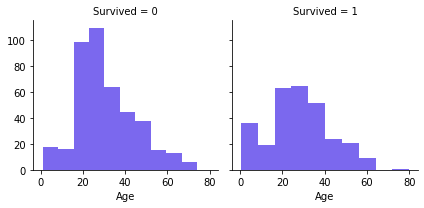

In [10]:
# df into a grid of rows and columns that correspond to levels of variables in the dataset.
# col (or row) = variables that define subsets of the data, which will be drawn on separate facets in the grid
grid = sns.FacetGrid(train_data, col="Survived")

# grid.map(plotting_function, col name) applies a plotting function to each facet’s subset of the data.

grid.map(plt.hist, "Age", color = "mediumslateblue")


Now below we observe correlations combining more features (**Age**, **Pclass**, Survived) and comparing them.

We can see that it's relevant the high number of 20 years old people not survived of third class.

It seems that 80 years old people were just in first class and survived.

Most of the middle age passengers (15-40 y.o.) were in third class, which is the most populated.

We have the highest number of survived people in the first class, the higest number of not survived is in the third one.



At the end of Age and Pclass analysis, we can consider to keep these 2 features for our predictions, because they are highly correlated with the Survived one.



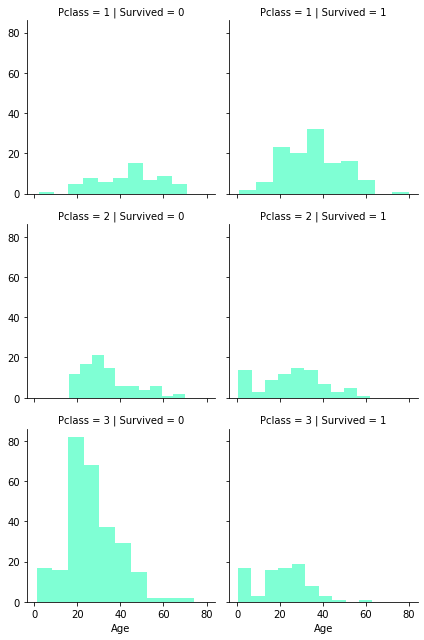

In [11]:
# return a grid of subsets define by the combination of 2 features
grid_2 = sns.FacetGrid(train_data, col='Survived', row='Pclass')
#map the grid using hist plot
grid_2.map(plt.hist, "Age", color = "aquamarine")

Now we compare **Embarked** with Survived feature, distinguishing by **Sex**.

In particular we can notice that an high number of female people in first and third classes embarked from Queenstown and Southampton. 

It's also evident the high percentage of male survived passengers in second and first class, embarked from Cherbourg port.

/Users/livialilli/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/livialilli/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


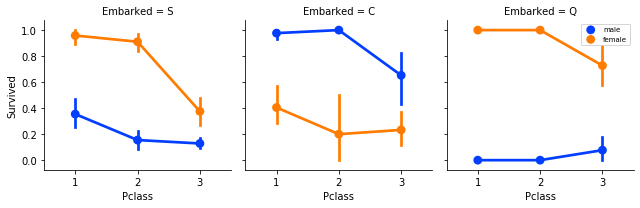

In [12]:
# return a grid of subsets defined by Embarked feature
grid_3 = sns.FacetGrid(train_data, col="Embarked")

#mapping grid with pointplot
#as inputs 3 features
grid_3.map(sns.pointplot, "Pclass", "Survived","Sex",palette="bright")

#adding a legend
plt.legend(loc="upper right",prop={'size': 7})

Always analyzing these 3 features with **Fare**, we make an other kind of plots.

It's easy to see that in general, survivors correspond to higer values of fare, especially for the ones embarked from Queenstown port.

/Users/livialilli/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


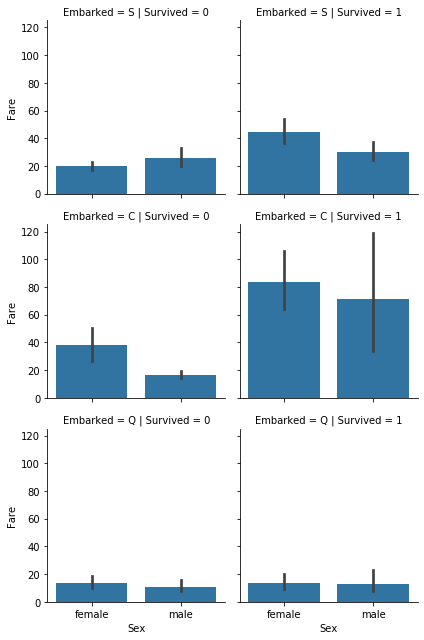

In [13]:
# return grid of subsets defined by 2 features
grid_4 = sns.FacetGrid(train_data, col = "Survived", row="Embarked")

#mapping them with a barplot (sex is categorical)
grid_4.map(sns.barplot, "Sex", "Fare")

From this accurate data exploration, we decide to keep the following features for our prediction model:
    
* Pclass

* Sex

* Embarked

* Fare

* Age

Another, we can say that for sure we will exlude:

* PassengerId

And we have to make futher analysis about:

* Ticket

* Cabin

* Parch

* SibSp

* Name

>## Missing Values

In [14]:
### missing values detection
def missing_values(df):
    

    # isnull() return the df with True if corresponding value is missing, otherwise False.
    # sum() return for each col label, the sum of tot missing values.
    # sort_values(..) to sort df by descending order of values.
    total = df.isnull().sum().sort_values(ascending = False)

    # percent return df sorted by descent order of values.
    # for each column label of the original df gives the percentage of missing values (n miss value/n tot value).
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    
    # return df that is concatenation of total and percent dfs.
    ms =pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    # consider just ms with percent of missing values > 0.
    ms =ms[ms.Percent>0]
    
    #plot of percentages.
    sns.set(style="whitegrid")
    plt.figure(figsize=(9, 6))
    ax = sns.barplot(x=np.asarray(ms.index),y="Percent",data=ms, alpha = 0.8)

    #ax.set_ylim(0,100)
    plt.show()
    return ms

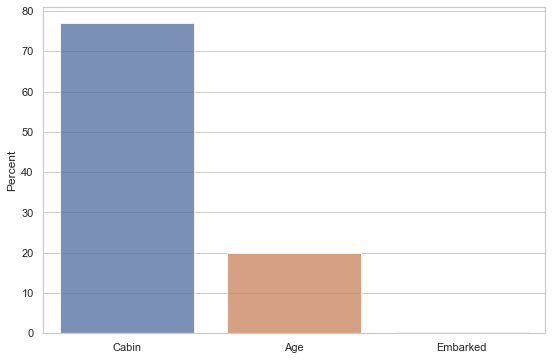

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


In [15]:
missing_values(train_data)

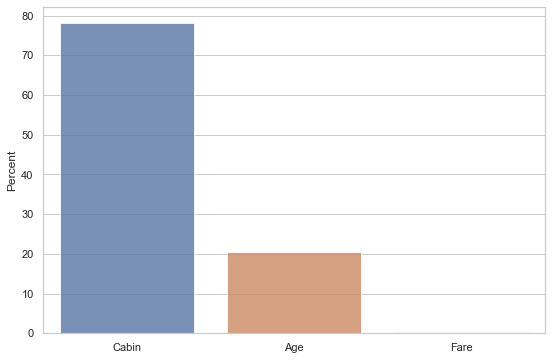

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


In [16]:
missing_values(test_data)

>> ### Embarked 


Embarked has a small percentage of missing values on the train set. It means that we can simply refill them. We choose as filling value the *mode*: it's the value which appears most often.

In [17]:
# df.fillna(value) return df with NA/NaN values filled with the specified one.
# (inplace = True) will make the changes permanent, without having to make a copy of the object.
# df.mode() return the value of df which appears most often.
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace = True)

>>### Fare 

Fare has few missing values on test set, for this we fill them with the *median*. In particular, given an ordered set of values, the median is the central values; if the number of elements in the set is even, than the median will be the mean of the 2 central values.

In [18]:
# fill Fare NA/Nan values with Fare median.
test_data["Fare"].fillna(test_data["Fare"].median(), inplace = True)

>> ### Cabin 

Cabin has a very high percentage of missing values in both dataframes, train and test. Then we can simply remove that column, It doesn't gives us useful informations.

In [19]:
# df.drop(column name, axis=1vertical, inplace to keep in memory the modification)
test_data.drop("Cabin", axis = 1, inplace = True)
train_data.drop("Cabin", axis= 1, inplace = True)

>>### Age

Age has about the 15% percent of missing values in test and train dfs, so we can just refill them with the *median*.

In [20]:
train_data["Age"].fillna(train_data["Age"].median(), inplace = True)

In [21]:
test_data["Age"].fillna(test_data["Age"].median(), inplace=True)

In [22]:
#check cabin and PassengerId drop on test

test_data.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [23]:
#check cabin and PassengerId drop on train
train_data.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

# Data Wrangling

Let's start creating new datasets, that are similar to the original but without including PassengerID Feature. However we mantain it to the orginial train and test sets, because we will need it in creating output

In [24]:
#seeing columns
train_data.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [25]:
train_withoutID = train_data[['Pclass','Sex','Age','SibSp','Parch','Ticket','Fare','Embarked','Name','Survived']]

test_withoutID = test_data[['Pclass','Sex','Age','SibSp','Parch','Ticket','Fare','Embarked','Name']]





>## Sex conversion in numerical values


Sex values:

* Female = 0

* Male = 1

In [26]:
#sex conversion on train 
train_withoutID.Sex[train_withoutID.Sex=="female"] = 0
train_withoutID.Sex[train_withoutID.Sex == "male"] = 1

In [27]:
#sex conversion on test
test_withoutID.Sex[test_withoutID.Sex=="female"] = 0
test_withoutID.Sex[test_withoutID.Sex == "male"] = 1

In [28]:
#check
train_withoutID.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name,Survived
0,3,1,22.0,1,0,A/5 21171,7.2500,S,"Braund, Mr. Owen Harris",0
1,1,0,38.0,1,0,PC 17599,71.2833,C,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
2,3,0,26.0,0,0,STON/O2. 3101282,7.9250,S,"Heikkinen, Miss. Laina",1
3,1,0,35.0,1,0,113803,53.1000,S,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
4,3,1,35.0,0,0,373450,8.0500,S,"Allen, Mr. William Henry",0


In [29]:
#check
test_withoutID.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name
0,3,1,34.5,0,0,330911,7.8292,Q,"Kelly, Mr. James"
1,3,0,47.0,1,0,363272,7.0000,S,"Wilkes, Mrs. James (Ellen Needs)"
2,2,1,62.0,0,0,240276,9.6875,Q,"Myles, Mr. Thomas Francis"
3,3,1,27.0,0,0,315154,8.6625,S,"Wirz, Mr. Albert"
4,3,0,22.0,1,1,3101298,12.2875,S,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)"


In [30]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [31]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


>## Embarked conversion to numerical

* C = Cherbourg =0

* Q = Queenstown = 1

* S = Southampton = 2

In [32]:
train_withoutID.Embarked[train_withoutID.Embarked =="C"] =0
train_withoutID.Embarked[train_withoutID.Embarked =="Q"] =1
train_withoutID.Embarked[train_withoutID.Embarked =="S"] =2


In [33]:
test_withoutID.Embarked[test_withoutID.Embarked =="C"] =0
test_withoutID.Embarked[test_withoutID.Embarked =="Q"] =1
test_withoutID.Embarked[test_withoutID.Embarked =="S"] =2


In [34]:
#check on train
train_withoutID.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name,Survived
0,3,1,22.0,1,0,A/5 21171,7.2500,2,"Braund, Mr. Owen Harris",0
1,1,0,38.0,1,0,PC 17599,71.2833,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
2,3,0,26.0,0,0,STON/O2. 3101282,7.9250,2,"Heikkinen, Miss. Laina",1
3,1,0,35.0,1,0,113803,53.1000,2,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
4,3,1,35.0,0,0,373450,8.0500,2,"Allen, Mr. William Henry",0


In [35]:
#check on test
test_withoutID.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name
0,3,1,34.5,0,0,330911,7.8292,1,"Kelly, Mr. James"
1,3,0,47.0,1,0,363272,7.0000,2,"Wilkes, Mrs. James (Ellen Needs)"
2,2,1,62.0,0,0,240276,9.6875,1,"Myles, Mr. Thomas Francis"
3,3,1,27.0,0,0,315154,8.6625,2,"Wirz, Mr. Albert"
4,3,0,22.0,1,1,3101298,12.2875,2,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)"


>## Age

# Output

In [36]:


### output
def output_file(predictions):
    
    output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
    output.to_csv('my_submission.csv', index=False)
    print("Your submission was successfully saved!")

In [37]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_withoutID[features])
X_test = pd.get_dummies(test_withoutID[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [38]:
X

,Pclass,SibSp,Parch,Sex_0,Sex_1
0,3,1,0,0,1
1,1,1,0,1,0
2,3,0,0,1,0
3,1,1,0,1,0
4,3,0,0,0,1
...,...,...,...,...,...
886,2,0,0,0,1
887,1,0,0,1,0
888,3,1,2,1,0
889,1,0,0,0,1


In [39]:
X_test

,Pclass,SibSp,Parch,Sex_0,Sex_1
0,3,0,0,0,1
1,3,1,0,1,0
2,2,0,0,0,1
3,3,0,0,0,1
4,3,1,1,1,0
...,...,...,...,...,...
413,3,0,0,0,1
414,1,0,0,1,0
415,3,0,0,0,1
416,3,0,0,0,1
